In [1]:
# from kalmanutils import validate_geoms_matrix, interpolate_geometries
import farsiteutils_v2 as futils
import uuid
import datetime

import pandas as pd
import geopandas as gpd

from shapely.geometry import MultiPolygon, Polygon, Point, GeometryCollection
from shapely.validation import make_valid

from matplotlib import pyplot as plt
import numpy as np

import random 
import pickle

/opt/conda/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [8]:
def plot_geometry(geom, ax = None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    if isinstance(geom, MultiPolygon):
        for g in geom.geoms:
            x,y = g.exterior.coords.xy
            ax.plot(x[:-1],y[:-1], **kwargs)
    else:
        x,y = geom.exterior.coords.xy
        ax.plot(x[:-1],y[:-1], **kwargs)
        
    ax.set_aspect('equal')
        
def plot_matrix(X, ax=None, show_stdev = False, **kwargs):
    vcounts = X.shape[0]//2
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
    
    color = (1,0,0,0.9)
    if 'color' in kwargs:
        color = kwargs['color']
        
    X_std = np.std(X, axis=1)
    X_mean = np.mean(X, axis=1)
    ax.plot(X_mean[::2], X_mean[1::2], **kwargs)

    # Calculate standard deviation of the generated coordinates
    x0, y0 = X_mean[::2], X_mean[1::2]
    radstd = np.zeros_like(x0)
    
    for vix in range(vcounts):
        x,y = X[2*vix,:], X[2*vix+1,:]
        radius = np.sqrt((x-x0[vix])**2 +(y-y0[vix])**2)
        radstd[vix] = np.std(radius)
    
    if show_stdev:
        for vix in range(vcounts):
            circle = plt.Circle((x0[vix], y0[vix]), radius=radstd[vix], fill=False, edgecolor=(0,0,0,0.4), lw=0.3)
            ax.add_artist(circle)
            
    ax.set_aspect('equal')

def plot_matrix_ensemble(X, ax=None, plot_alix = None, alpha=0.1, **kwargs):
    
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(4,4))
        
    for vix in range(X.shape[1]):
        ax.plot(X[::2, vix], X[1::2, vix], **kwargs)
        
    if plot_alix is not None:
        ax.scatter(X[2*plot_alix,:], X[2*plot_alix+1, :], alpha = alpha, color=kwargs['color'], edgecolors=(0,0,0,0))
    ax.set_aspect('equal')

def calculate_rms(geom1, geom2):
    xy1, xy2 = interpolate_geometries([geom1, geom2], vertex_count=100)
    xy1, xy2 = align_vertices([xy1, xy2])
    return np.sqrt(np.sum((xy1[:,0] - xy2[:,0])**2 + (xy1[:,1] - xy2[:,1])**2)/xy1.shape[0])
    

def calculate_area_diff(geom1, geom2):
    return (geom1.union(geom2) - geom1.intersection(geom2)).area

In [25]:
with open('/home/jovyan/data/output_maria_08302023.pkl', 'rb') as f:
    data = pickle.load(f)

In [26]:
with open('/home/jovyan/data/maria_zero_observation_sim_08312023.pkl', 'rb') as f:
    zero_info_sim = pickle.load(f)

In [23]:
SELECTED_FIRE_DEFAULT = 'Maria2019'
DATA_PATH = '/home/jovyan/data/'    # Folder to keep all the data while running the simulations

# Create handles for simulation
fp = futils.FilePaths(DATA_PATH)
usr = futils.User(fp)

# ignition is a 100x100 square from the centroid
cx, cy = gpd.read_file(usr.db.dfObservation.iloc[0]['filepath'])['geometry'][0].centroid.xy
cx = cx[0]
cy = cy[0]
size = 100

# Collect observations
maria_observations = []
for i in range(10):
    dfrow = usr.db.dfObservation.iloc[i]
    geom = gpd.read_file(dfrow['filepath'])['geometry'][0]
    
    maria_observations.append(geom)
    
windspeed_maria = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
winddirection_maria = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

Database interaction not yet implemented. Use pickle file for dataframes instead!


(1502331.9045202376, 1506642.8140704648)

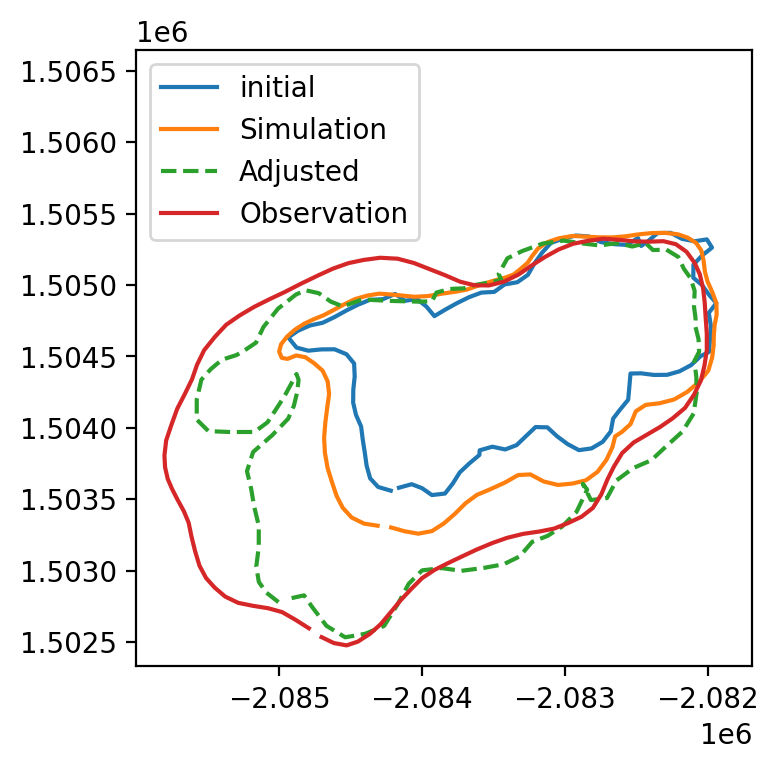

In [44]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
plot_geometry(data['calculations'][0]['initial_poly'], ax=ax, label='initial')
plot_matrix(data['calculations'][0]['Xt'], ax=ax, label='Simulation')
plot_matrix(data['calculations'][0]['X'], ax=ax, label='Adjusted', ls='--')
plot_matrix(data['calculations'][0]['Y'], ax=ax, label='Observation')
# plot_geometry(zero_info_sim[1], ax=ax, label='initial')

ax.legend(loc='upper left')
ax.set_xlim((-2085996.9918134266, -2081689.1908660273))
ax.set_ylim((1502331.9045202376, 1506642.8140704648))

In [32]:
ax.get_xlim(), ax.get_ylim()

((-2085996.9918134266, -2081689.1908660273),
 (1502331.9045202376, 1505539.8140704648))